# Analytics
#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 
### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- Caio César de Almeida Beleza
- João Victor Lustosa Braz
- Lucas Lopes Xavier
- André Macedo Rodrigues Alves
- Arthur José Nascimento de Lima
- Cícero Barrozo Fernandes Filho
- Daniel Rocha Oliveira
- Gabriel de Souza Fonseca Ribeiro
- Matheus Raphael Soares de Oliveira
- Pedro Victor Lima Torreão

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add your path here

In [5]:
jsons

['../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Profile-04-20-2022-14-25-26-v3.4.1.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022-23-14-35-v3.0.7-test.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-04-13-2022-13-24-50-v4.8.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-04-01-2022-10-41-30-v3.1.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-04-13-2022-14-09-15-v4.8.1.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-04-13-2022-13-32-45-v3.3.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Profile-04-20-2022-14-25-26-v3.4.1-test.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-04-01-2022-10-42-10-v4.6.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-04-01-2022-10-41-30-v3.1.0-test.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-04-20-2022-14-31-42-v3.4.0-test.json',
 '../analytics-raw-data/fga-eps-mds-202

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        if i.endswith("-test.json"):
            continue

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021-2-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[3]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [7]:
base_component_df = create_base_component_df(jsons)

/tmp/ipykernel_141291/3308325655.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_141291/3308325655.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_141291/3308325655.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_141291/3308325655.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_141291/3308325655.py:25: FutureWarning: The frame.append method is deprec

In [8]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
81,duplicated_lines_density,2.4,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
82,functions,375,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
83,security_rating,1.0,True,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
84,files,109,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
85,complexity,525,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
86,ncloc,7026,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
87,coverage,13.9,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
88,reliability_rating,1.0,True,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
89,comment_lines_density,1.6,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
99,duplicated_lines_density,0.0,True,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,03,3.3.1


In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [10]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:
        
        if i.endswith("-test.json"):
            continue

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        
        test_file = i.replace(".json", "-test.json")
        
        test_json = read_json(test_file)

        file_component_df['tests'] = 1
        try:
            file_component_df['test_execution_time'] = test_json['test_execution_time']
        except:
            time = (test_json['testResults'][0]['endTime'] - test_json['testResults'][0]['startTime'])/1000
            file_component_df['test_execution_time'] = time

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"Oraculo-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [11]:
file_component_df = create_file_df(jsons)
#file_component_df.repository.unique()
#file_component_df.head(10)

/tmp/ipykernel_141291/1133146952.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_141291/1133146952.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_141291/1133146952.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_141291/1133146952.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_141291/1133146952.py:57: FutureWarning: The frame.append method is deprec

In [12]:
front_df = file_component_df[file_component_df['repository'] == 'FrontEnd']
profile_df = file_component_df[file_component_df['repository'] == 'Profile']
registros_df = file_component_df[file_component_df['repository'] == 'Registros']

In [13]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,test_errors,test_failures,filename,repository,version
525,src/App.js,1,1,0.0,0.0,100.0,5,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
526,src/App.test.js,3,3,0.0,0.0,0.0,13,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
527,src/Auth/Auth.js,5,7,19.2,0.0,31.6,21,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
528,src/Services/Axios/BaseService/baseService.js,6,7,0.0,0.0,23.1,52,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
529,src/Constants/baseUrls.js,0,1,28.6,0.0,71.4,20,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
530,src/Components/DropDownButton/DivSelectSetor.js,0,0,0.0,0.0,100.0,23,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
531,src/Constants/federativeUnits.js,0,0,0.0,0.0,100.0,29,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
532,src/history.js,0,0,0.0,0.0,100.0,3,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
533,src/index.js,0,0,20.0,0.0,0.0,12,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
534,src/Pages/EditRecord/index.js,25,40,0.9,0.0,1.0,321,1.0,1,100.0,8.949,1.0,0,0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7


In [14]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

In [15]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

In [16]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

In [17]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [18]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

In [19]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

In [20]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

In [21]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [22]:
front_metrics = create_metrics_df(front_df)
profile_metrics = create_metrics_df(profile_df)
registros_metrics = create_metrics_df(registros_df)

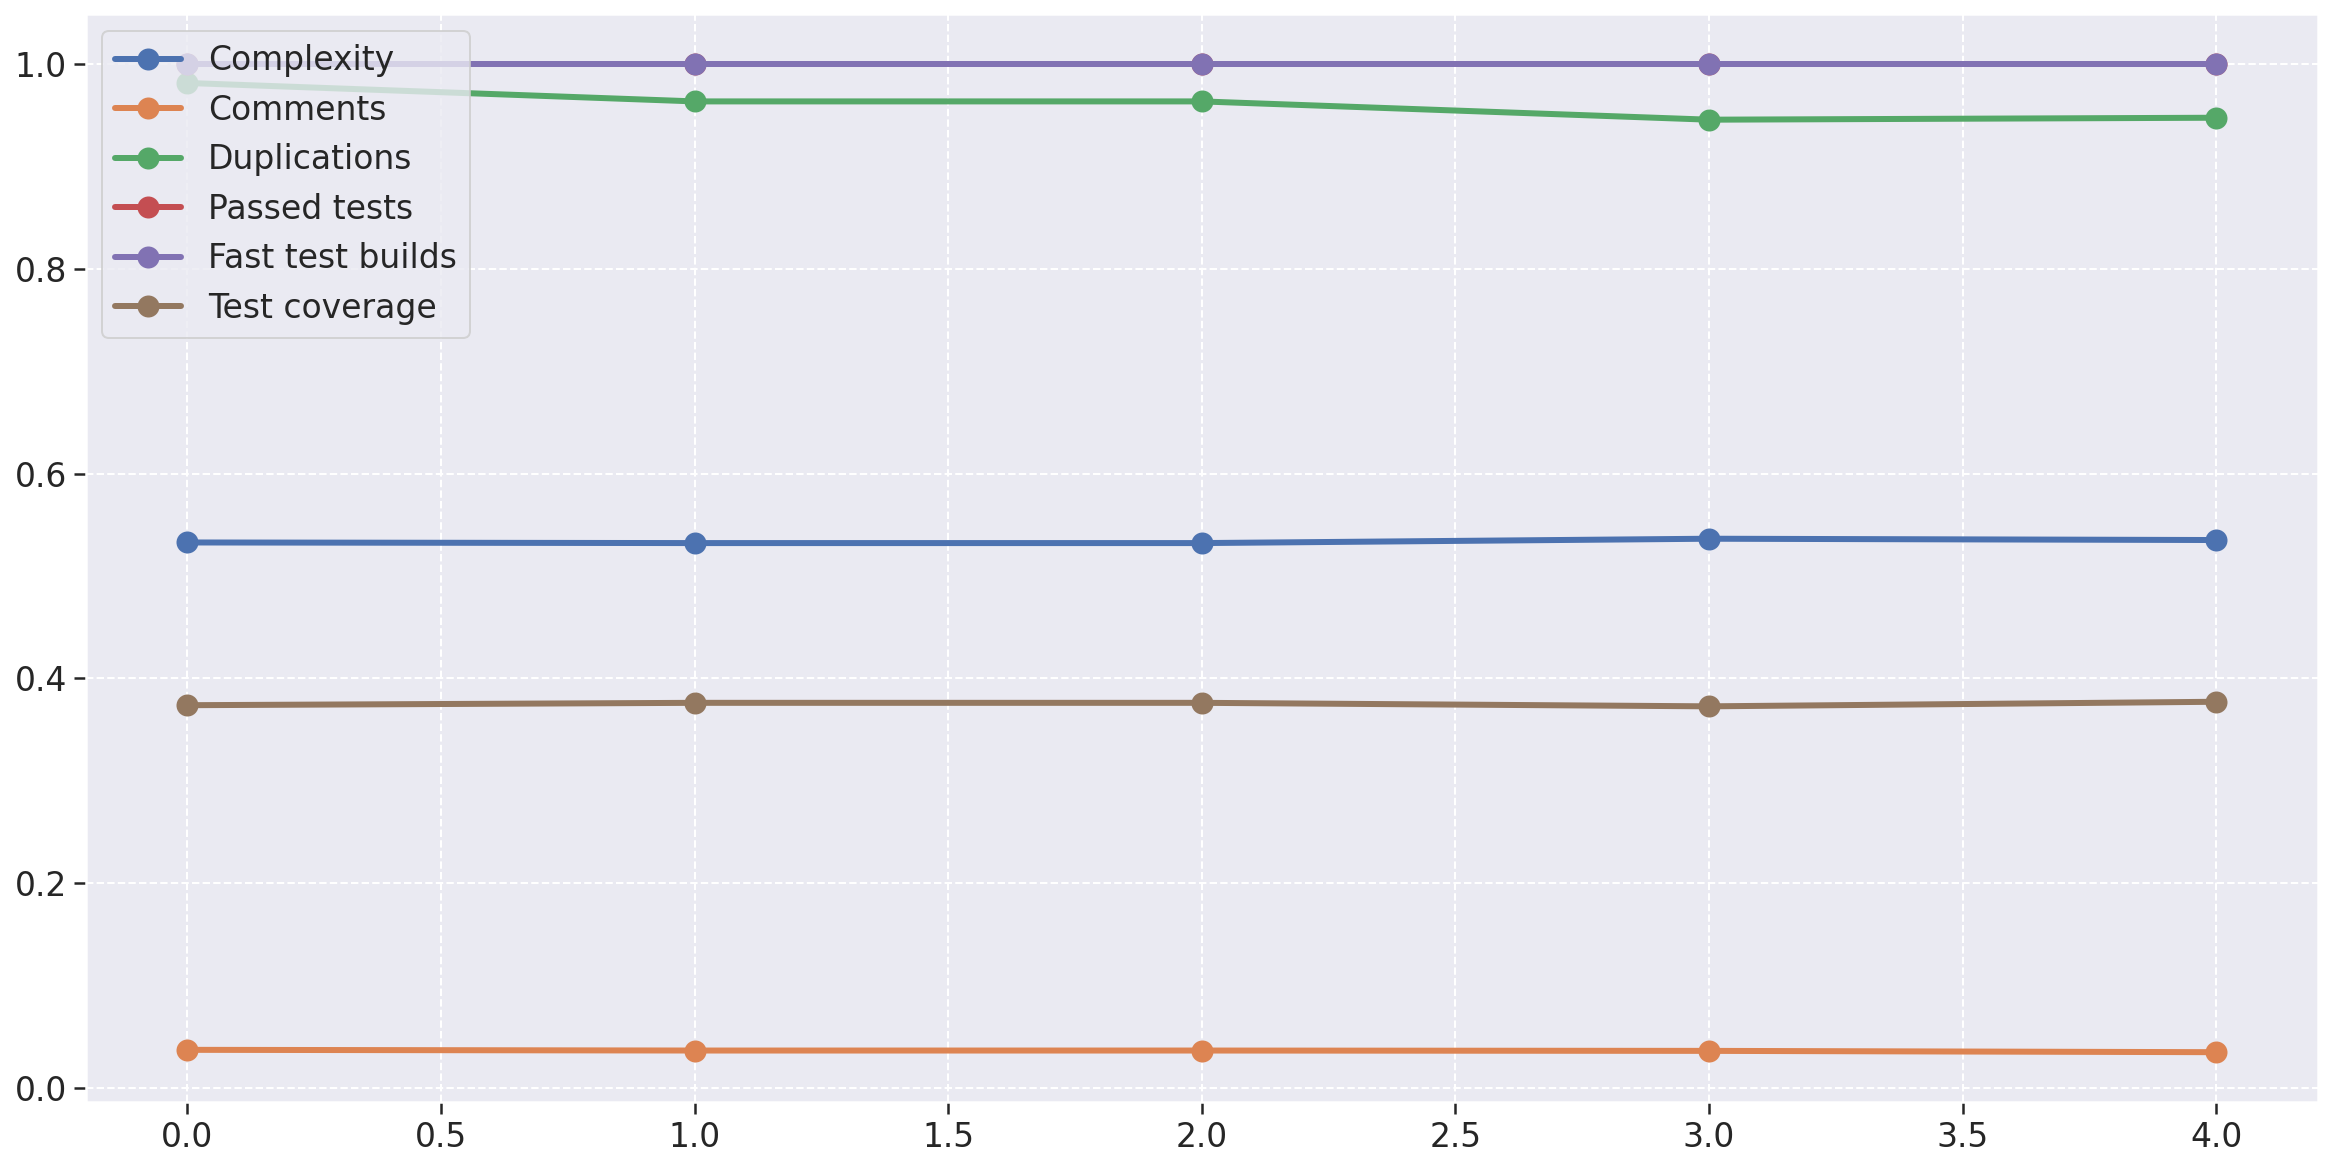

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.plot(front_metrics['m1'], label='Complexity', linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m2'], label='Comments', linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m3'], label='Duplications', linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m4'], label='Passed tests', linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m5'], label='Fast test builds', linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m6'], label='Test coverage', linewidth=3, marker='o', markersize=10)
plt.legend(loc='upper left')

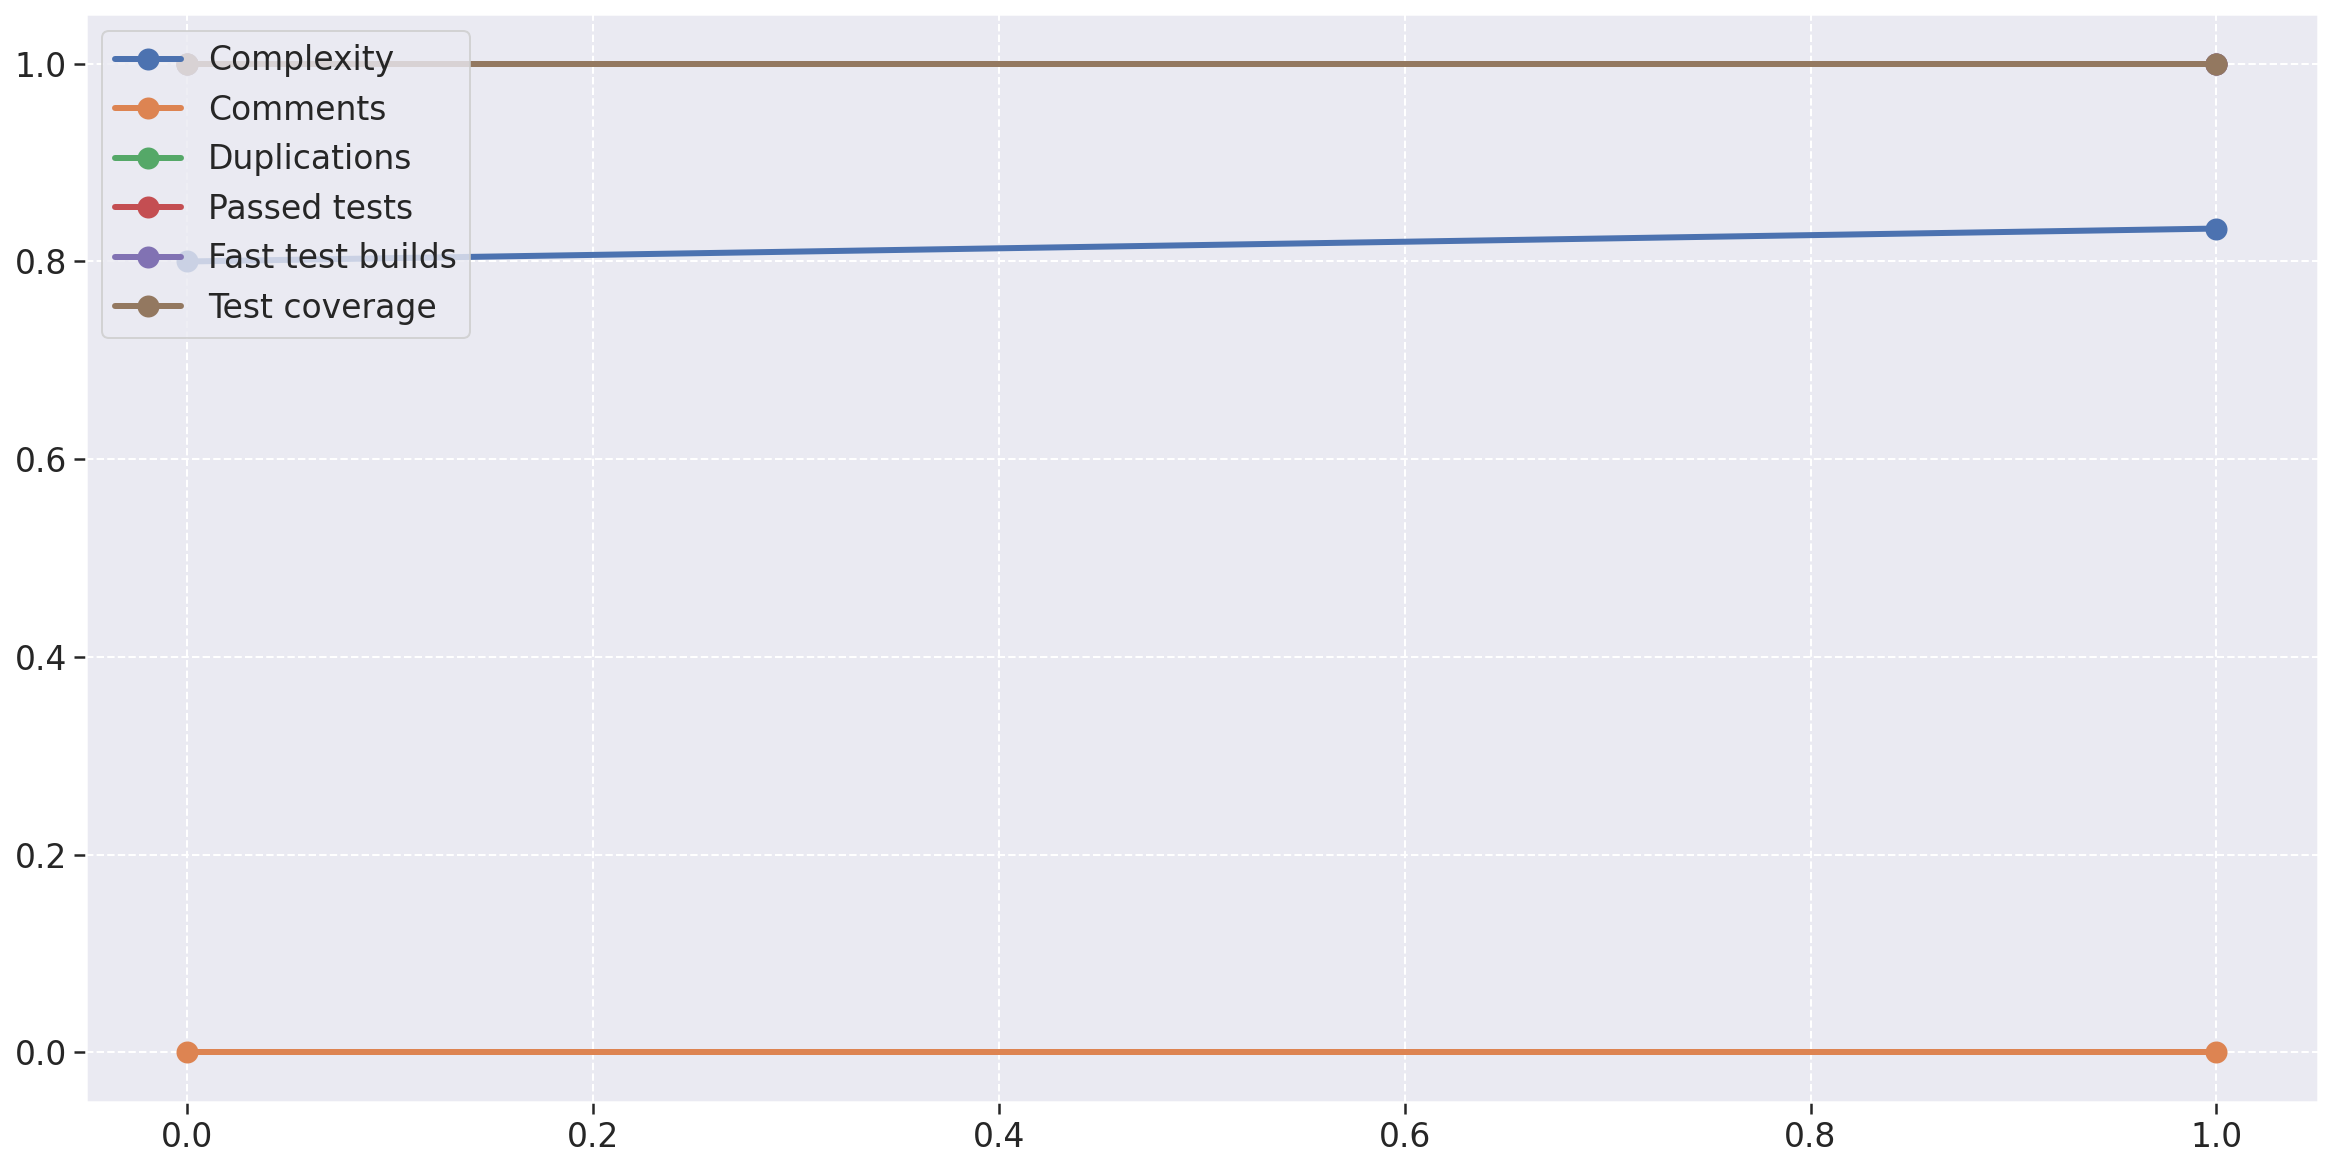

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m1'], label='Complexity', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m2'], label='Comments', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m3'], label='Duplications', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m4'], label='Passed tests', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m5'], label='Fast test builds', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m6'], label='Test coverage', linewidth=3, marker='o', markersize=10)
plt.legend(loc='upper left')

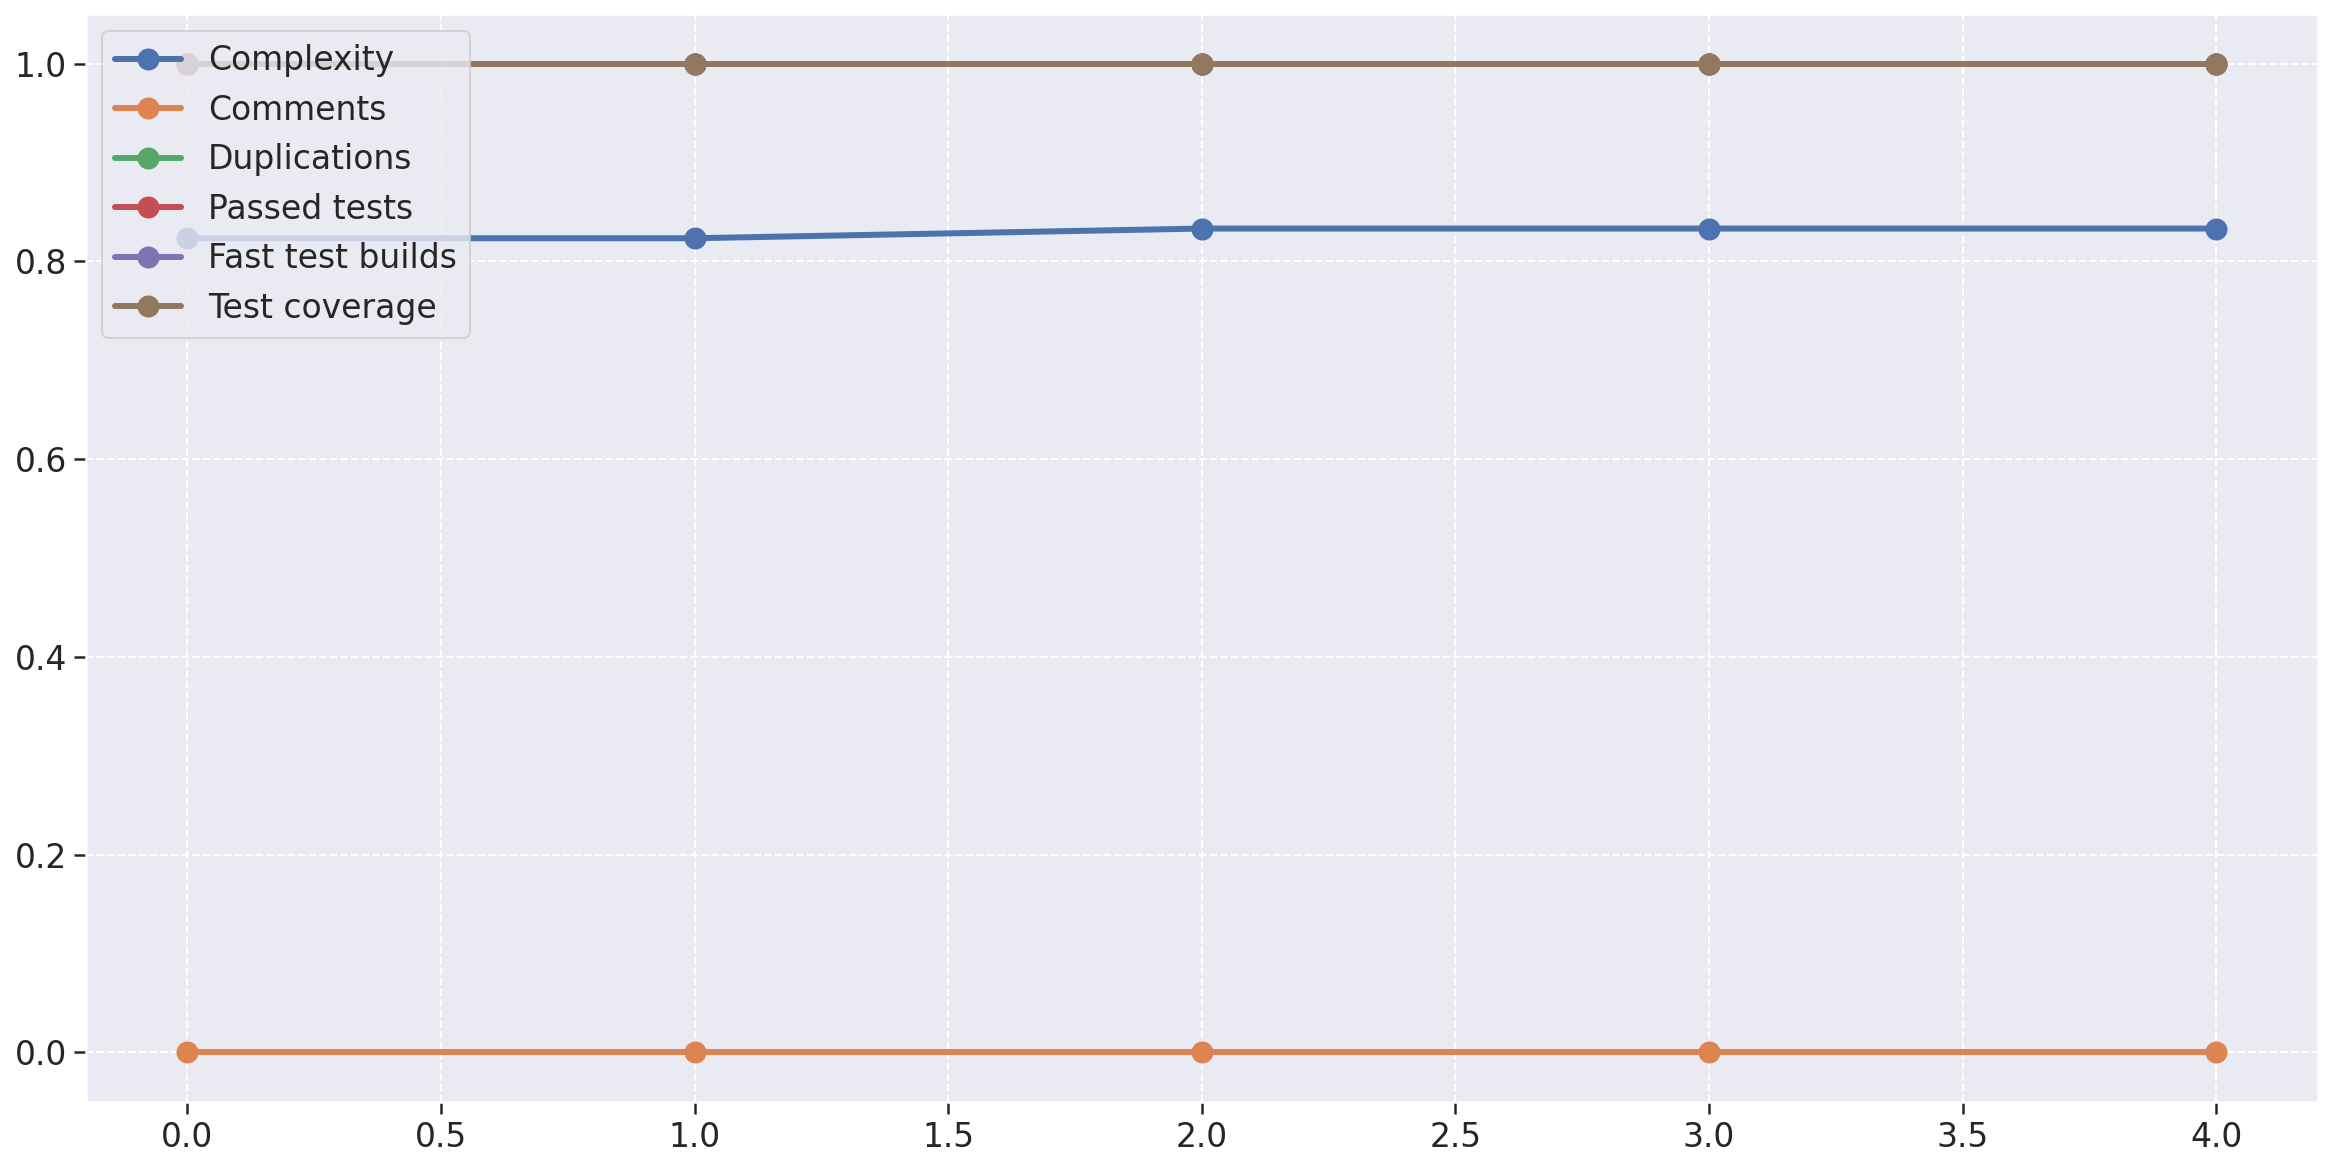

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(registros_metrics['m1'], label='Complexity', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m2'], label='Comments', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m3'], label='Duplications', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m4'], label='Passed tests', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m5'], label='Fast test builds', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m6'], label='Test coverage', linewidth=3, marker='o', markersize=10)
plt.legend(loc='upper left')

In [26]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

front_metrics['code_quality'] = ((front_metrics['m1']*pm1) + (front_metrics['m2']*pm2) + (front_metrics['m3']*pm3)) * psc1
profile_metrics['code_quality'] = ((profile_metrics['m1']*pm1) + (profile_metrics['m2']*pm2) + (profile_metrics['m3']*pm3)) * psc1
registros_metrics['code_quality'] = ((registros_metrics['m1']*pm1) + (registros_metrics['m2']*pm2) + (registros_metrics['m3']*pm3)) * psc1


front_metrics['testing_status'] = ((front_metrics['m4']*pm4) + (front_metrics['m5']*pm5) + (front_metrics['m6']*pm6)) * psc2
profile_metrics['testing_status'] = ((profile_metrics['m4']*pm4) + (profile_metrics['m5']*pm5) + (profile_metrics['m6']*pm6)) * psc2
registros_metrics['testing_status'] = ((registros_metrics['m4']*pm4) + (registros_metrics['m5']*pm5) + (registros_metrics['m6']*pm6)) * psc2

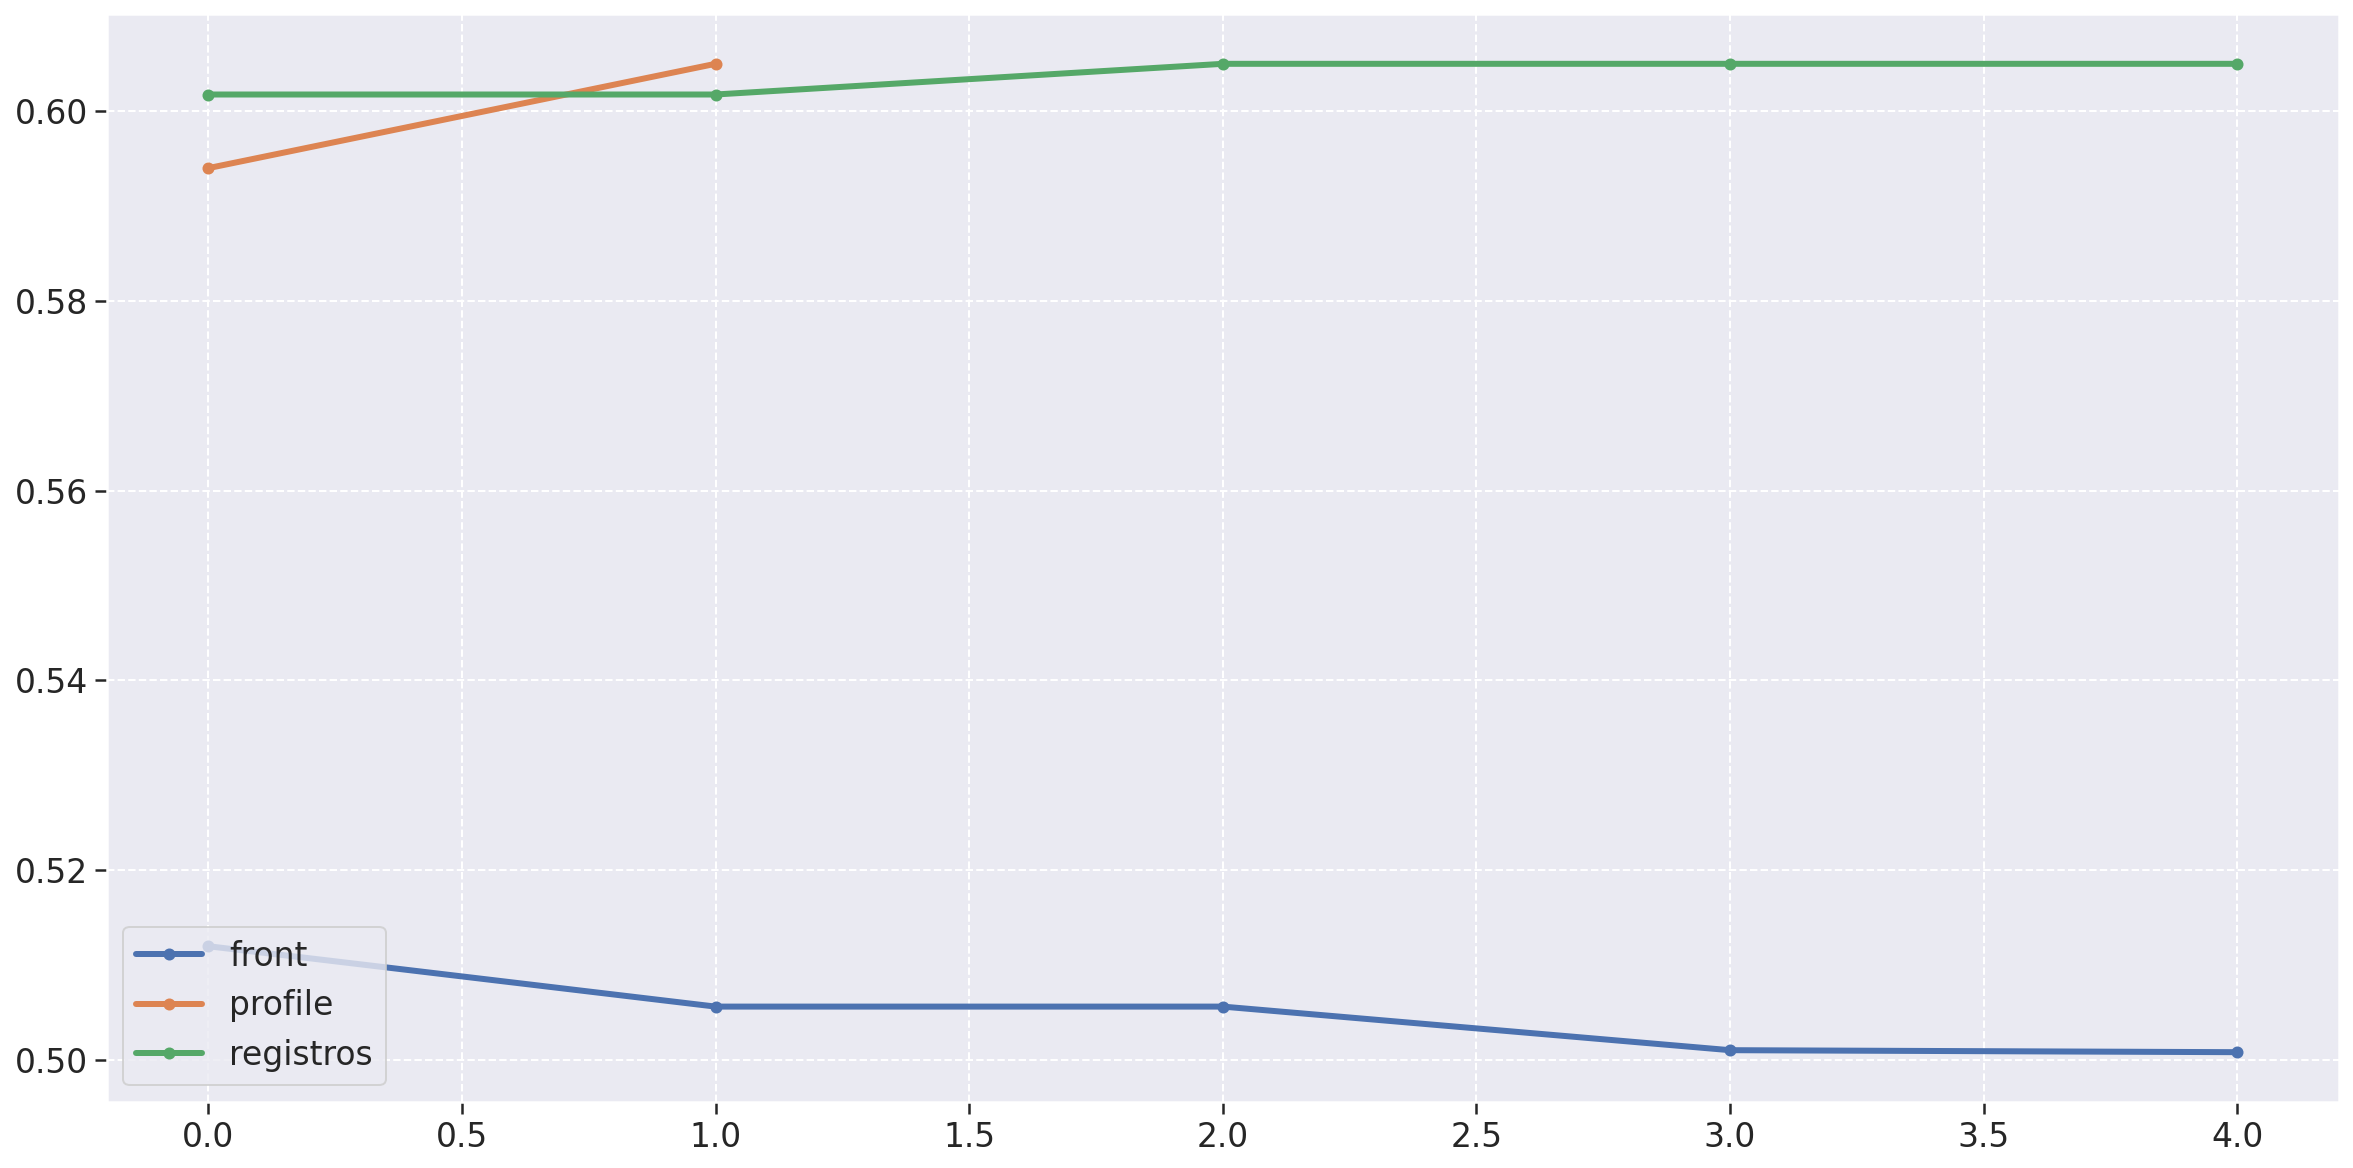

In [27]:
fig = plt.figure(figsize=(20, 10))


plt.plot(front_metrics['code_quality'], label='front',linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['code_quality'], label='profile', linewidth=3, marker='o', markersize=5)
plt.plot(registros_metrics['code_quality'], label='registros', linewidth=3, marker='o', markersize=5)

plt.legend(loc='lower left')

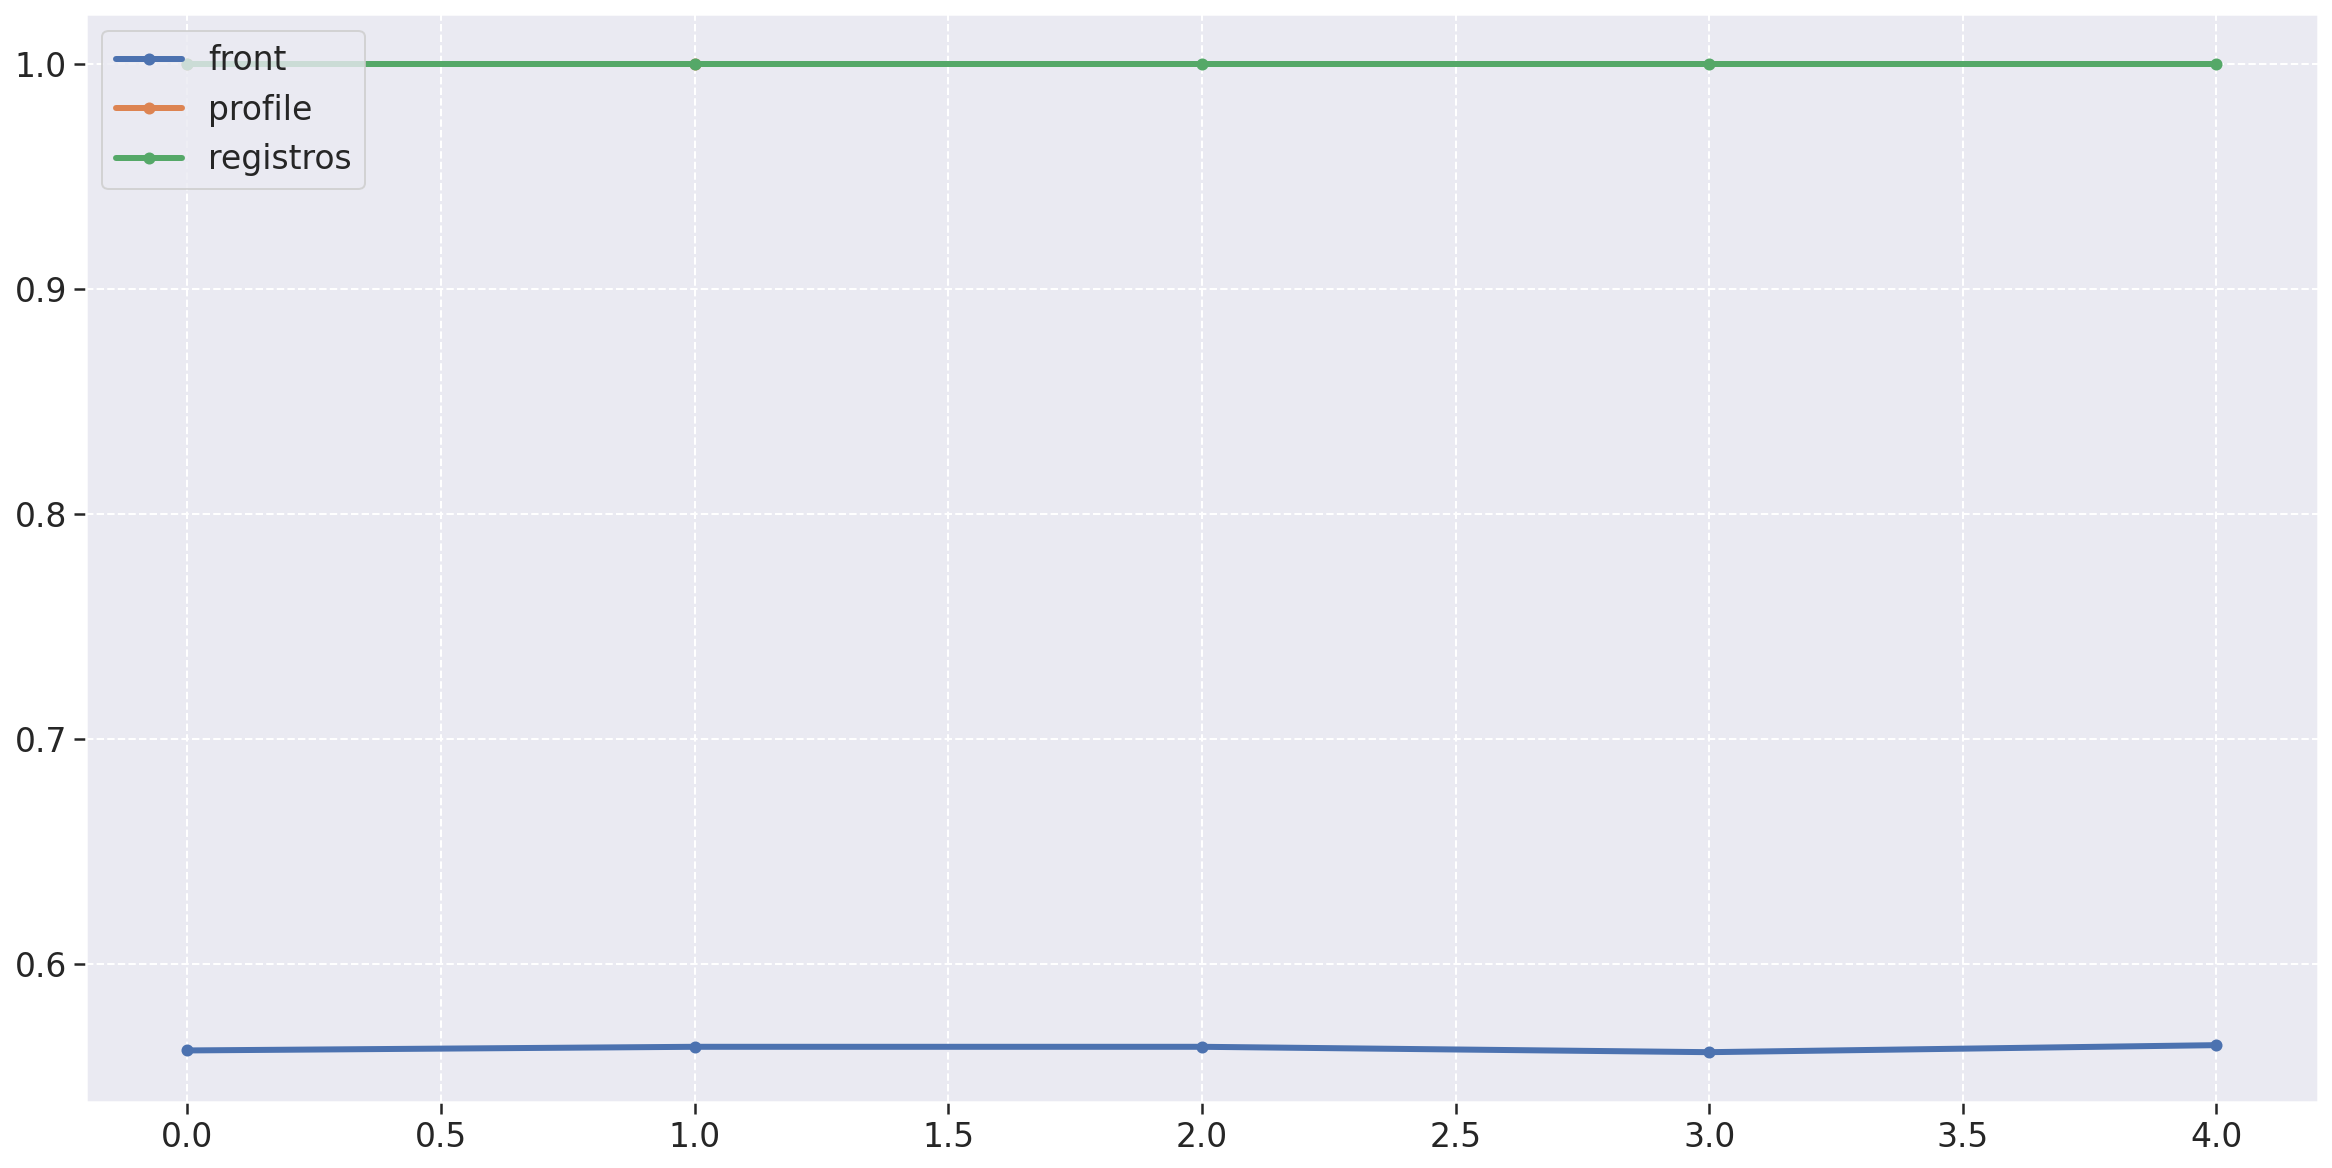

In [28]:
fig = plt.figure(figsize=(20, 10))


plt.plot(front_metrics['testing_status'], label='front',linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['testing_status'], label='profile',linewidth=3, marker='o', markersize=5)
plt.plot(registros_metrics['testing_status'], label='registros',linewidth=3, marker='o', markersize=5)

plt.legend(loc='upper left')

In [29]:
metrics_df = pd.concat([front_metrics, profile_metrics, registros_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [30]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.532710,0.037383,0.981308,1.0,1.0,0.373832,FrontEnd,03-25-2022-23-14-35-v3.0.7,6981,0.511963,0.561682,0.255981,0.280841,0.536822
1,0.532110,0.036697,0.963303,1.0,1.0,0.376147,FrontEnd,04-01-2022-10-41-30-v3.1.0,7144,0.505596,0.563303,0.252798,0.281651,0.534450
2,0.532110,0.036697,0.963303,1.0,1.0,0.376147,FrontEnd,04-08-2022-12-56-05-v3.2.0,7220,0.505596,0.563303,0.252798,0.281651,0.534450
3,0.536364,0.036364,0.945455,1.0,1.0,0.372727,FrontEnd,04-13-2022-13-32-45-v3.3.0,7467,0.501000,0.560909,0.250500,0.280455,0.530955
4,0.535088,0.035088,0.947368,1.0,1.0,0.377193,FrontEnd,04-20-2022-14-31-42-v3.4.0,7765,0.500789,0.564035,0.250395,0.282018,0.532412
5,0.800000,0.000000,1.000000,1.0,1.0,1.000000,Profile,03-27-2022-18-59-14-v3.3.1,479,0.594000,1.000000,0.297000,0.500000,0.797000
6,0.833333,0.000000,1.000000,1.0,1.0,1.000000,Profile,04-20-2022-14-25-26-v3.4.1,597,0.605000,1.000000,0.302500,0.500000,0.802500
7,0.823529,0.000000,1.000000,1.0,1.0,1.000000,Registros,03-26-2022-18-26-26-v4.5.2,978,0.601765,1.000000,0.300882,0.500000,0.800882
8,0.823529,0.000000,1.000000,1.0,1.0,1.000000,Registros,04-01-2022-10-42-10-v4.6.0,984,0.601765,1.000000,0.300882,0.500000,0.800882
9,0.833333,0.000000,1.000000,1.0,1.0,1.000000,Registros,04-08-2022-12-57-08-v4.7.0,1062,0.605000,1.000000,0.302500,0.500000,0.802500


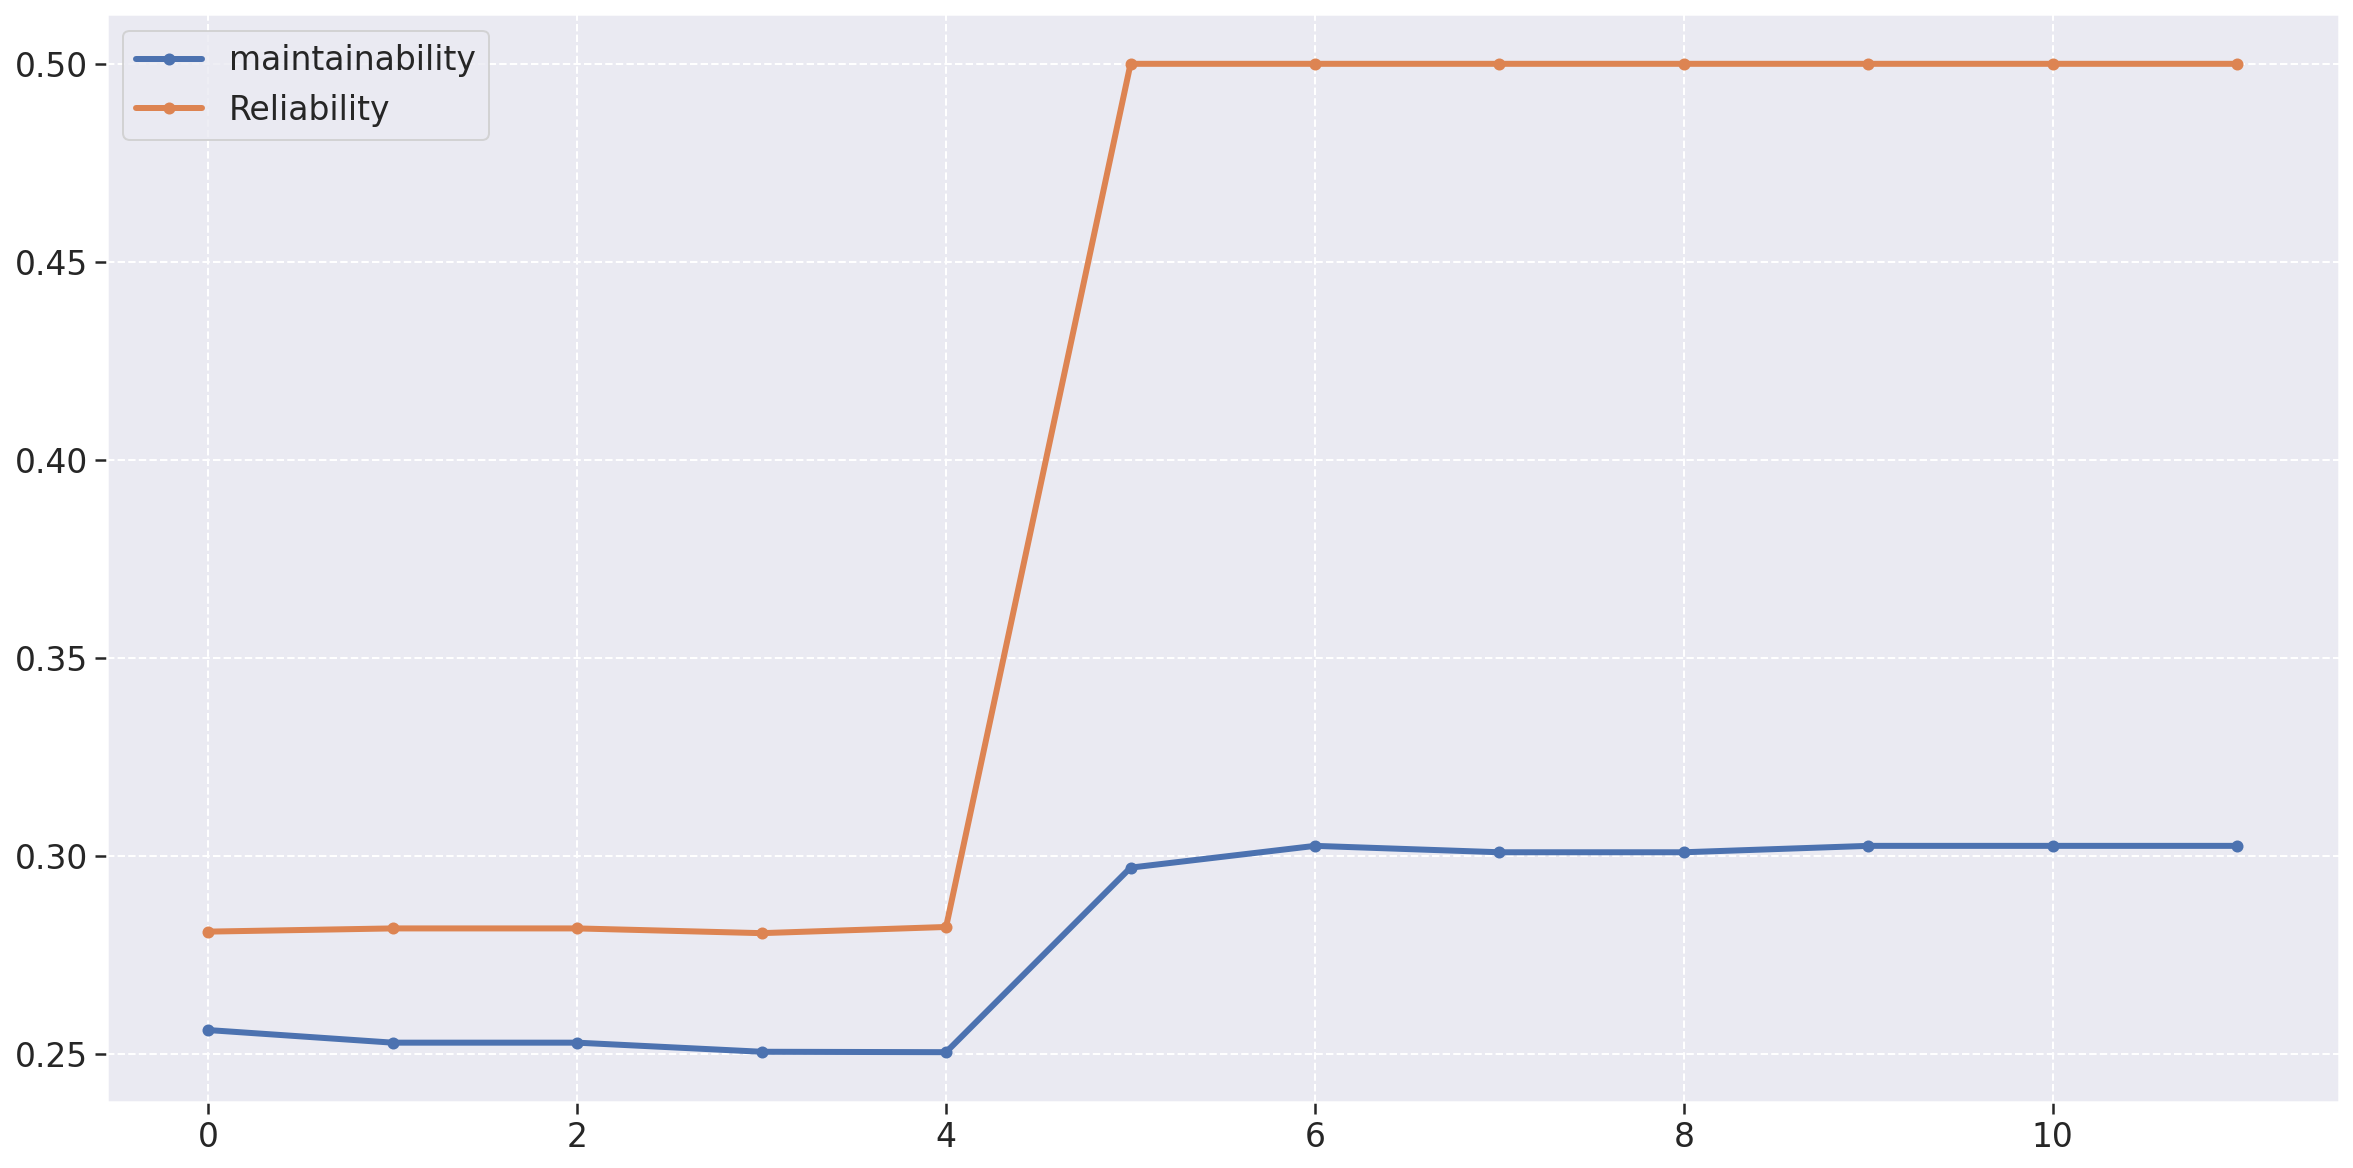

In [31]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], label='maintainability', linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], label='Reliability',linewidth=3, marker='o', markersize=5)

plt.legend(loc='upper left')
#plt.ylim(.45,.7)

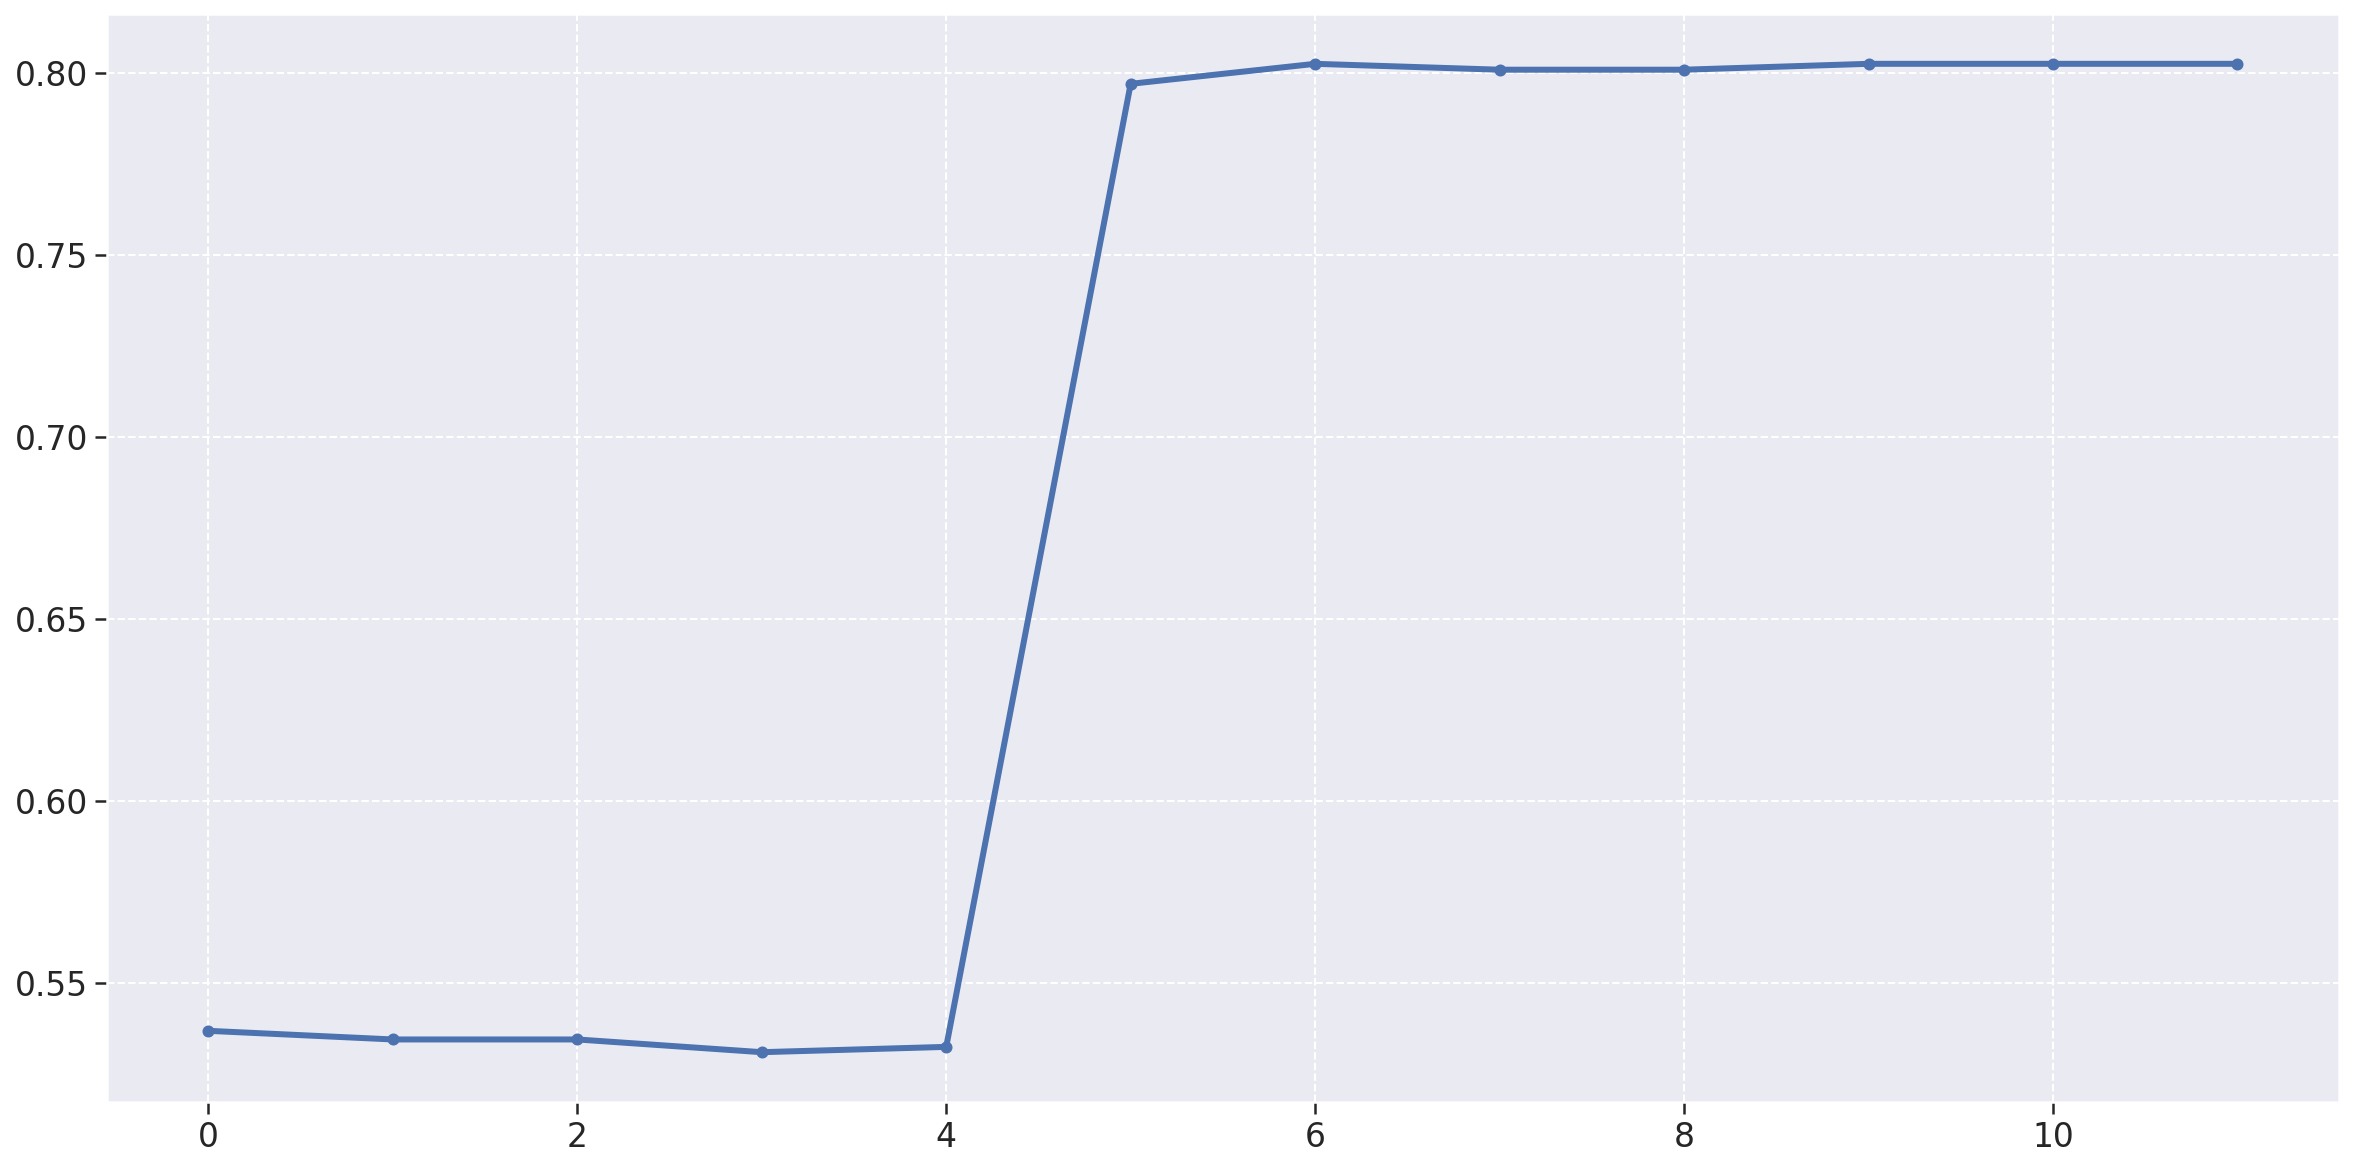

In [32]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


#plt.ylim(.45,.7)

In [33]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('data/fga-eps-mds-2021-2-Oraculo-DATASET-{}.xlsx'.format(currentDateTime), index = False)
metrics_df.to_csv('data/fga-eps-mds-2021-2-Oraculo-DATASET-{}.csv'.format(currentDateTime), index = False)